In [9]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

In [ ]:
!CUDA_VISIBLE_DEVICES=0

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
def count_tokens(x):
    return len(x.split())

In [45]:
# max min mean 
df = pd.read_csv('data/train.csv')
df['tokens'] = df.text.map(lambda x: count_tokens(x))
df.tokens.agg(["max","min","mean"])

max     75.000000
min      1.000000
mean    17.384472
Name: tokens, dtype: float64

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'data'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=32, device=device, train=False, shuffle=False, sort=False)

In [12]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [15]:

# Training Function
destination_folder = 'output'
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 1,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
        for (text, labels), _ in tqdm(train_loader, desc='training examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/1], Step [890/1780], Train Loss: 0.0521, Valid Loss: 0.0225
Model saved to ==> output/model.pt
Model saved to ==> output/metrics.pt
Epoch [1/1], Step [1780/1780], Train Loss: 0.0020, Valid Loss: 0.0257


Model saved to ==> output/metrics.pt
Finished Training!


Model loaded from <== output/metrics.pt


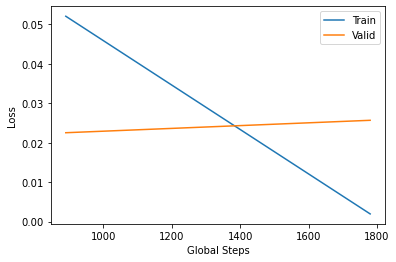

In [16]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [17]:

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in tqdm(test_loader, desc='Testing examples'):
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== output/model.pt



Classification Report:
              precision    recall  f1-score   support

           1     0.9892    0.9989    0.9940      3744
           0     0.9989    0.9890    0.9940      3744

    accuracy                         0.9940      7488
   macro avg     0.9940    0.9940    0.9940      7488
weighted avg     0.9940    0.9940    0.9940      7488



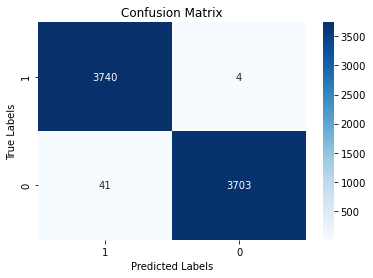

In [18]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)
evaluate(best_model, test_iter)

# SC-GPT evaluation

In [19]:
# Load SC-GPT Results to evaluate coherence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'sc_gpt'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

test = TabularDataset.splits(path=source_folder, test='mw_sc_gpt.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

test_iter = Iterator(test[0], batch_size=16, device=device, train=False, shuffle=False, sort=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== output/model.pt



Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.9901    0.9950      7372
           0     0.0000    0.0000    0.0000         0

    accuracy                         0.9901      7372
   macro avg     0.5000    0.4950    0.4975      7372
weighted avg     1.0000    0.9901    0.9950      7372



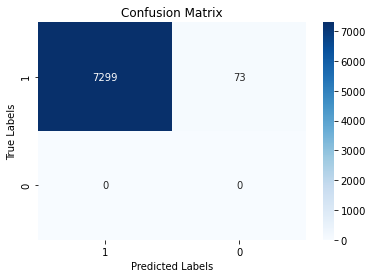

In [20]:
destination_folder = 'output'
#load model and send it to the GPU
best_model = BERT().to(device)

#load the checkpoint
load_checkpoint(destination_folder + '/model.pt', best_model)

#evaluate
evaluate(best_model, test_iter)